# Exploring the Determinants of Health expenditures: A Comparison Between Ordinary Least Squares, the Heckman Selectivity Model, and Polynomial Logit with Newey’s selection correction

In [67]:
#only do insured or not, and then health expenditures. No need to model whether expenditures is 0 or positive first. 
#but; do sensitivity analysis to see whether those 0 observations change much in the results. 
#So e.g. throw all 0 obs. away and see what happens, or do a log(expenditures + 1) transformation and see what happens

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pyreadstat
import statsmodels.api as sm
from patsy import dmatrices
from scipy import optimize
import patsy
from tabulate import tabulate 
from scipy import stats
from scipy.stats import norm
import scipy as sc
from scipy.sparse import diags
from scipy.stats import logistic

## being insured is endogenous, according to Shen (2013)
being insured or not is endogenous, so what are the possible instruments for this dummy? Shen : "The biggest marginal effect on the probability of having insurance comes from marital status". Also: marriage, region, white, education, income level, industry insurance rate, occupation class, number of comorbidities, 

## now the expl. variables for healthcare expenditure according to Shen (2013)
- number of comorbidities
- presence of mental illnesses
- insurance (which is also a dependent variable --> endogenous)

So this is what we should take into account (see Shen):  "These studies treat insurance as exogenous and state that in so doing, the marginal impact of insurance has an upward bias. However, none of these studies has quantified the extent of this bias."

In [69]:
#dtafile = 'C:\\Users\\Administrator\\Desktop\\ME\h201.dta'
dtafile = 'C:\\Users\\Administrator\\Desktop\\ME\h201.dta'
df, meta = pyreadstat.read_dta(dtafile)

df = df[['INSCOV17','TOTEXP17','UNINS17','RXSLF17',
    'AGE17X', 'SEX','FAMS1231', 'EDUCYR','RACETHX', 'MARRY17X', 'REGION17', 'FAMINC17', 'OCCCAT31',
     'OBDRV17',    
    'MNHLTH31','HIBPDX','EMPST31', 'ADSMOK42',  'ASTHDX', 'ARTHDX', 'CANCERDX','DIABDX', 'EMPHDX', 'CHDDX', 'STRKDX']].copy()
#TOTEXP17 is dependent variable, in combination with a dummy insured
  
#keeping only age between 40-59 observations 
df = df[(df['AGE17X'] >= 40) & (df['AGE17X'] <= 59)]

df['SEX'] = df['SEX']-1

#TOTEXP17 (total expenditure) has no -1 values and is a numerical variable 
#take log(TOTEXP17 + 1) because some observations have 0 expenditure 
df['logtotexp']= np.log(df['TOTEXP17']+1)
df['totexp']= df['TOTEXP17']

# dummy for insurance coverage, 1 for insured, 0 for not insured
df['insured'] = np.where(df['UNINS17']==2,1,0)



In [70]:
#there are no missing values
df.isna().sum().sum()

0

In [71]:
df.describe()

,INSCOV17,TOTEXP17,UNINS17,RXSLF17,AGE17X,SEX,FAMS1231,EDUCYR,RACETHX,MARRY17X,...,ASTHDX,ARTHDX,CANCERDX,DIABDX,EMPHDX,CHDDX,STRKDX,logtotexp,totexp,insured
count,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,...,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000,8010.000000
mean,1.448315,5601.474282,1.870162,155.302871,49.610986,0.540699,2.907366,12.806617,2.129963,2.112484,...,1.851561,1.716479,1.904120,1.852310,1.955556,1.937328,1.945318,6.152423,5601.474282,0.870162
std,0.712087,17393.926449,0.336146,703.597926,5.792041,0.498372,1.720705,3.896518,0.973344,1.540223,...,0.575492,0.705571,0.518645,0.565178,0.474098,0.547248,0.483728,3.236613,17393.926449,0.336146
min,1.000000,0.000000,1.000000,0.000000,40.000000,0.000000,-1.000000,-9.000000,1.000000,-8.000000,...,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,0.000000,0.000000,0.000000
25%,1.000000,179.000000,2.000000,0.000000,45.000000,0.000000,2.000000,12.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.192957,179.000000,1.000000
50%,1.000000,1113.000000,2.000000,10.000000,50.000000,1.000000,3.000000,13.000000,2.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,7.015712,1113.000000,1.000000
75%,2.000000,4263.000000,2.000000,100.000000,55.000000,1.000000,4.000000,16.000000,3.000000,3.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.357962,4263.000000,1.000000
max,3.000000,499286.000000,2.000000,30213.000000,59.000000,1.000000,13.000000,17.000000,5.000000,5.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,13.120936,499286.000000,1.000000


### dependent variable

insurance

In [72]:
print(df['INSCOV17'].value_counts())
print(df['UNINS17'].value_counts())

1.0    5459
2.0    1511
3.0    1040
Name: INSCOV17, dtype: int64
2.0    6970
1.0    1040
Name: UNINS17, dtype: int64


1: any private  
2: public only  
3: uninsured 

<BarContainer object of 3 artists>

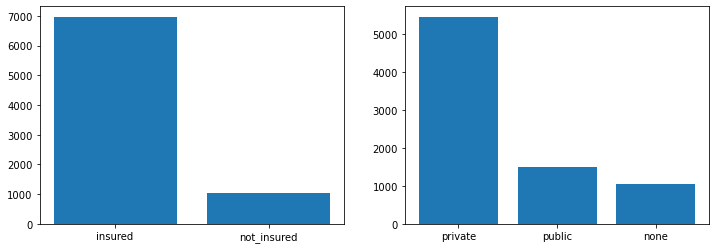

In [73]:
df['PRIV_INSUR'] = np.where(df['INSCOV17']==1, 1, 0)
df['PUBL_INSUR'] = np.where(df['INSCOV17']==2, 1, 0)

fig,axes=plt.subplots(1,2,figsize=(12,4))

axes[0].bar(('insured','not_insured'), (sum(df['insured']==1),sum(df['insured']==0)),width=0.8)
axes[1].bar(('private','public','none'), (sum(df['PRIV_INSUR']==1),sum(df['PUBL_INSUR']==1),sum(df['insured']==0)))

expenditure

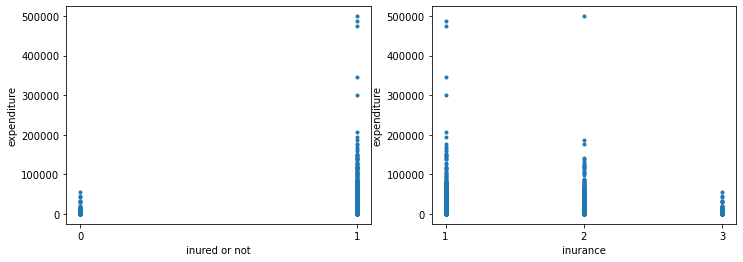

In [74]:
df['logtotexp']= np.log(df['TOTEXP17']+1)
df['totexp']= df['TOTEXP17']

fig,ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].plot(df['insured'], df['totexp'], '.')
ax[0].set_xlabel('inured or not')
ax[0].set_ylabel('expenditure')
ax[0].set_xticks((0,1))

ax[1].plot(df['INSCOV17'], df['totexp'], '.')
ax[1].set_xlabel('inurance')
ax[1].set_ylabel('expenditure')
ax[1].set_xticks((1,2,3))

Majority of people have private insurance, and in America, public insurance refers to government-funded health insurance programs that provide coverage for certain eligible individuals, such as old people(>65), people with certain disabilities, low-income individuals and families, pregnant women, children, eligible military veterans, and people with disabilities or end-stage renal disease.\
So public insuance plays an important role in providing health care coverage to people who may not be able to afford it, investigating the relation between healthcare expenditure and public insurance can have improtant policy implications. 





### expanatory variables

<AxesSubplot:xlabel='EDUCYR'>

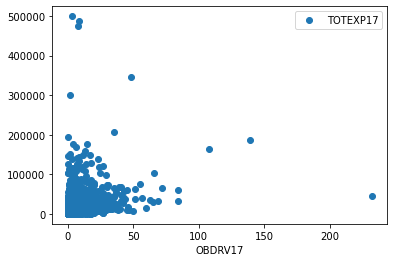

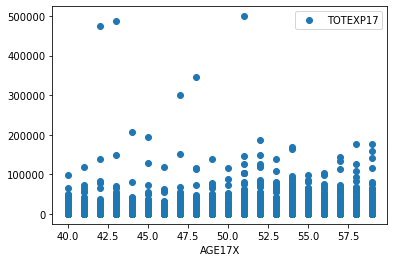

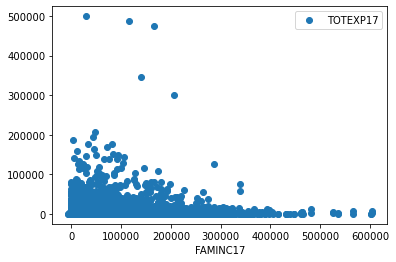

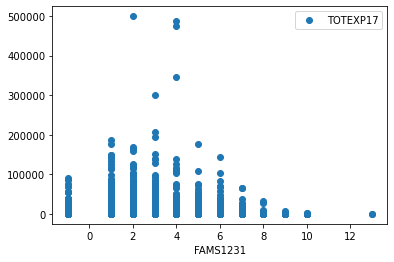

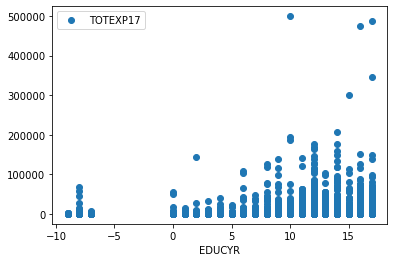

In [75]:
#plots for numerical variables and categorical variables with clear order
df.plot(x='OBDRV17', y='TOTEXP17', style='o')
df.plot(x='AGE17X', y='TOTEXP17', style='o')
df.plot(x='FAMINC17', y='TOTEXP17', style='o')
df.plot(x='FAMS1231', y='TOTEXP17', style='o')
df.plot(x='EDUCYR', y='TOTEXP17', style='o')

<AxesSubplot:>

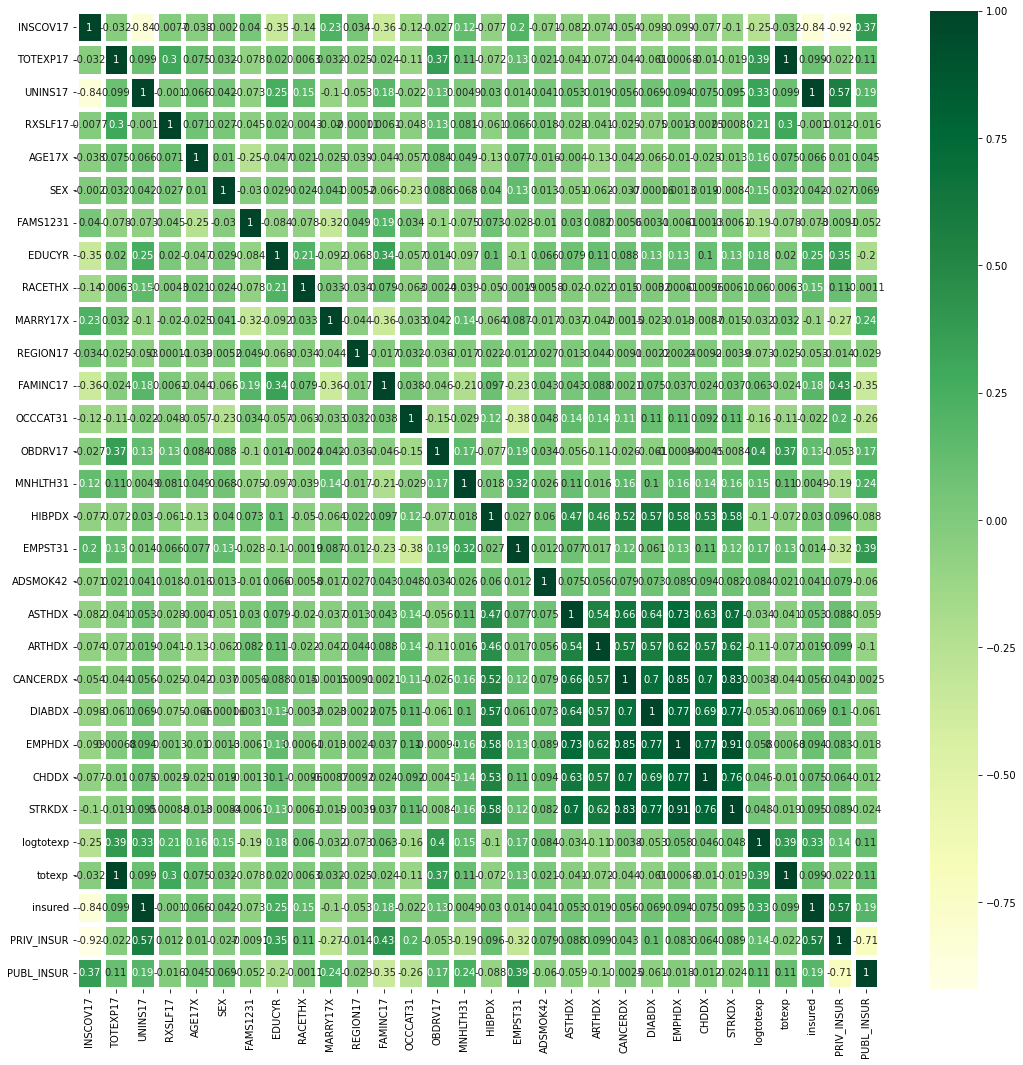

In [76]:
#correlation matrix to check for multicollinearity, we see that HIBPDX (high blood pressure) and the comorbidities ASTHDX - STRKDX are highly correlated with each other.
#therefore, we create a variable 
corr = df.corr()
f, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corr, ax=ax, annot=True, linewidths=5,cmap='YlGn')

In [77]:
# dummy for smoking 
df = df.drop(df[df['ADSMOK42'] < 0].index)
df['smoker'] = np.where(df['ADSMOK42']== 1, 1,0)       

# dummy for race
df['white'] = np.where(df['RACETHX'] == 2, 1, 0)

# dummy for married
df = df.drop(df[df['MARRY17X'] < 0].index)
df['married'] = np.where(df['MARRY17X']==1, 1, 0)

# dummy for occupation category
df['whitecollar'] = np.where((df['OCCCAT31']== 1) | (df['OCCCAT31']== 2) | (df['OCCCAT31']== 3) | (df['OCCCAT31']== 4) | (df['OCCCAT31']== 5), 1,0) #1 MANAGEMENT, BUSINESS, AND FINANCIAL OCCUPATIONS, 2 PROFESSIONAL AND RELATED OCCUPATIONS, 3 SERVICE OCCUPATIONS, 4 SALES AND RELATED OCCUPATIONS, 5 OFFICE AND ADMINISTRATIVE SUPPORT 

# dummies for region (1: northeast, 2: midwest, 3: south, 4:west)
df = df.drop(df[df['REGION17'] < 0].index)
df['regionNE'] = np.where(df['REGION17']== 1, 1,0)
df['regionMW'] = np.where(df['REGION17']== 2, 1,0)
df['regionS'] = np.where(df['REGION17']== 3, 1,0) 
df['regionW'] = np.where(df['REGION17']== 4, 1,0)

In [78]:
# family size is numerical variable but has value -1
#merge catogories as 1-2, 3-4, >=5, use the last one as inference
df['FAM_SIZE_1and2'] = np.where(df['FAMS1231'].isin([1,2]),1,0)
df['FAM_SIZE_3and4'] = np.where(df['FAMS1231'].isin([3,4]),1,0)

# FAMINC19 (family income) is numerical variable and has no -1 (inapplicable) value
#take log(income +1) because some observations have 0 income 
df['familyincome']= np.log(df['FAMINC17']+1)

# years of education is numerical variable but has value -1,-8,-7,-15
df['yearseducation']=np.where((df['EDUCYR'] == -1) | (df['EDUCYR'] == -7) | (df['EDUCYR'] == -8) | (df['EDUCYR'] == -15), 0, df['EDUCYR']) #-1(inapplicable) means younger than 5

#AGE19X
df['age']= np.where(df['AGE17X']== -1, 50, df['AGE17X']) #50 is median value

In [79]:
#creating more dummies (e.g. for number of comorbidities)

df['mentalillness'] = np.where(df['MNHLTH31']> 3, 1, 0)  #1(execellent),2(very good),3(good),4(fair),5(poor)
df['highbloodpressure'] = np.where(df['HIBPDX']==1, 1, 0)   #1(yes),2(no)  #-1 means inapplicable 
df['employed'] = np.where((df['EMPST31']== 1) | (df['EMPST31']== 2) | (df['EMPST31']== 3), 1,0) #1(currently employed), 2(job to return to), 3(employed during the reference period), 4 (not employed with no job to return to)
df['asthma'] = np.where(df['ASTHDX']==1, 1, 0) 
df['arthritis'] = np.where(df['ARTHDX']==1, 1, 0)
df['cancer'] = np.where(df['CANCERDX']==1, 1, 0)
df['emphysema'] = np.where(df['EMPHDX']==1, 1, 0)
df['diabetes'] = np.where(df['DIABDX']==1, 1, 0) 
df['heartdisease'] = np.where(df['CHDDX']==1, 1, 0)
df['stroke'] = np.where(df['STRKDX']==1, 1, 0)
df['comorbidities'] =df['highbloodpressure'] + df['asthma']+df['arthritis']+df['cancer']+df['emphysema']+df['diabetes']+df['heartdisease']+df['stroke']

# number of comor=0 as reference
df['COMOR_1'] = np.where(df['comorbidities']==1,1,0)
df['COMOR_>1'] = np.where(df['comorbidities']>1,1,0)

In [80]:
#maybe we should censor or truncate the totexp?
#total healthcare exp:
print(df['totexp'].describe()) 

#log(TOTEXP17 + 1)
print(df['logtotexp'].describe())

print(df['RXSLF17'].describe())

df['logslf']=np.log(df['RXSLF17']+1)

count      6938.000000
mean       5898.881234
std       18206.347807
min           0.000000
25%         224.000000
50%        1258.500000
75%        4520.500000
max      499286.000000
Name: totexp, dtype: float64
count    6938.000000
mean        6.318626
std         3.158186
min         0.000000
25%         5.416100
50%         7.138470
75%         8.416599
max        13.120936
Name: logtotexp, dtype: float64
count     6938.000000
mean       163.690689
std        740.049452
min          0.000000
25%          0.000000
50%         13.000000
75%        110.000000
max      30213.000000
Name: RXSLF17, dtype: float64


In [139]:
#insured=private+public
#y, X = dmatrices('logtotexp ~ age + married + comorbidities + mentalillness + employed + smoker + white + familysize  + regionNE + regionMW + regionS + insured', data=df, return_type='matrix')
y, X = dmatrices('logtotexp ~ insured + age+ SEX+ FAM_SIZE_1and2 + FAM_SIZE_3and4 + comorbidities + mentalillness + OBDRV17 + familyincome ', data=df, return_type='matrix')

#and here also one for the insured part (1st step)
#y1, X1 = dmatrices('insured ~ age + married + comorbidities + mentalillness + employed + smoker + white + familyincome + familysize + yearseducation + regionNE + regionMW + regionS', data=df, return_type='matrix')
y1, X1 = dmatrices('insured ~ SEX \
                    +age\
                   + married \
                   + white \
                   + comorbidities \
                   + mentalillness \
                   + employed \
                   + familyincome \
                   + yearseducation \
                   + FAM_SIZE_1and2 \
                   + FAM_SIZE_3and4 \
                   + OBDRV17\
                   + regionNE + regionMW + regionS \
                   ', data=df, return_type='matrix')

#insured=public
dff=df[df['PRIV_INSUR']!=1]
yy, XX = dmatrices('logslf ~ PUBL_INSUR + SEX+ FAM_SIZE_1and2+FAM_SIZE_3and4+comorbidities + mentalillness + OBDRV17 + familyincome', data=dff, return_type='matrix')
yy1, XX1 = dmatrices('PUBL_INSUR ~ SEX\
                    +age\
                   + married \
                   + white \
                   + comorbidities \
                   + mentalillness \
                   + employed \
                   + familyincome \
                   + yearseducation \
                   + FAM_SIZE_1and2 \
                   + FAM_SIZE_3and4 \
                   + OBDRV17\
                   + regionNE + regionMW + regionS \
                   ', data=dff, return_type='matrix')

#insured=privite
dfff=df[df['PUBL_INSUR']!=1]
yyy, XXX = dmatrices('logslf ~ PRIV_INSUR + SEX+ FAM_SIZE_1and2+FAM_SIZE_3and4+comorbidities + mentalillness + OBDRV17 + familyincome', data=dfff, return_type='matrix')
yyy1, XXX1 = dmatrices('PRIV_INSUR ~ SEX \
                    +age\
                   + married \
                   + white \
                   + comorbidities \
                   + mentalillness \
                   + employed \
                   + familyincome \
                   + yearseducation \
                   + FAM_SIZE_1and2 \
                   + FAM_SIZE_3and4 \
                   + OBDRV17\
                   + regionNE + regionMW + regionS \
                   ', data=dfff, return_type='matrix')


<AxesSubplot:>

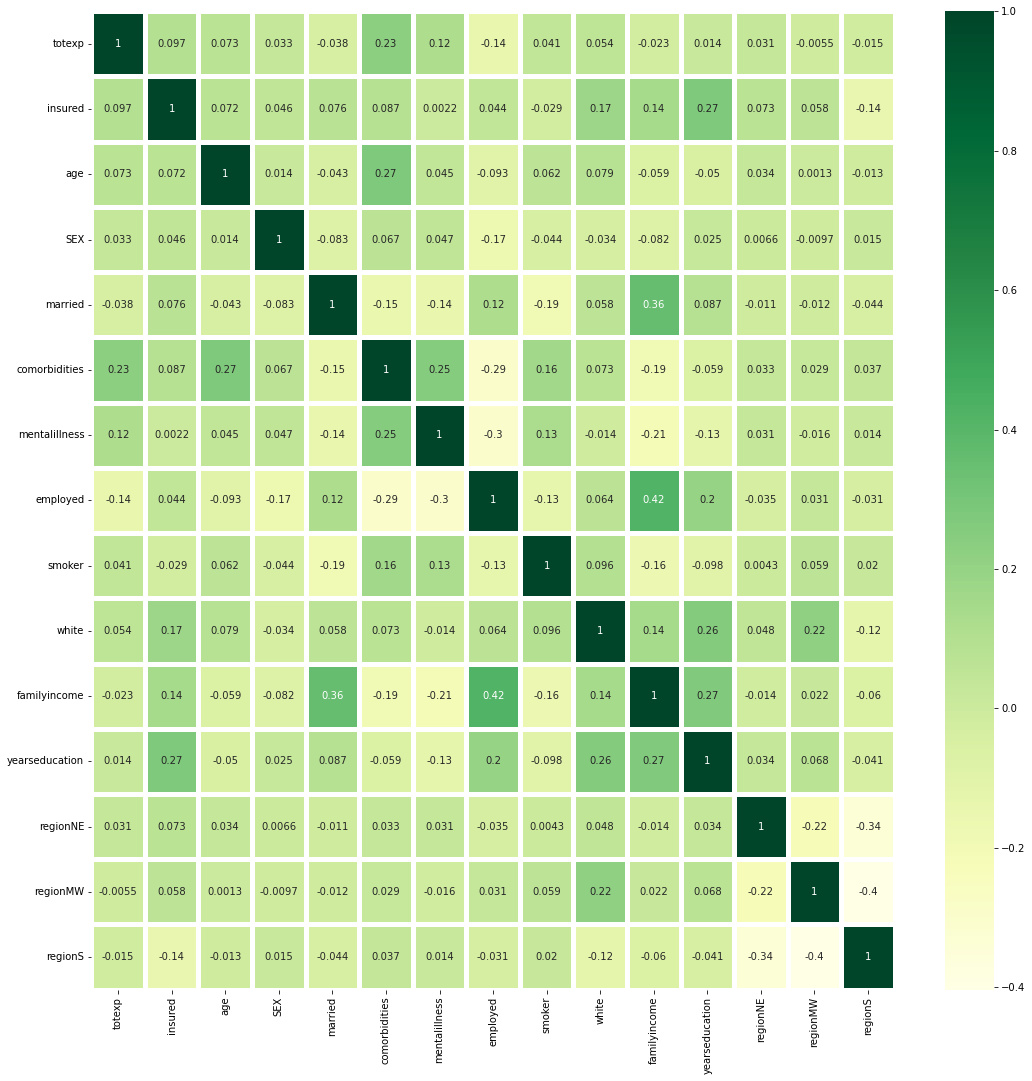

In [91]:
df1=df[['totexp', 'insured', 'age' , 'SEX', 'married' , 'comorbidities' , 'mentalillness' , 'employed' , 'smoker' , 'white', 'familyincome'  , 'yearseducation' , 'regionNE' , 'regionMW', 'regionS']]
corr = df1.corr()
f, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corr, ax=ax, annot=True, linewidths=5,cmap='YlGn')


## OLS

We begin with a simple equation approach using ordinary least squares, which
ignores sample selection and endogeneity. 

In [101]:
def OLS(y,X):
    N,k = X.shape                   # number of observations and regressors
    XXi = np.linalg.inv(X.T @ X)
    b_ols = XXi @ (X.T @ y)
    res = y-X @ b_ols
    s2 = (res.T @ res)/(N-k)   
    SE = np.sqrt(s2*np.diag(XXi))
    #heteroskedasticity-robust se ,  not sure if this is right
    V_hetero=XXi@X.T@sc.sparse.diags(np.squeeze(res**2))@X@XXi
    SE_hetero=np.sqrt(np.diag(V_hetero))
    
    return b_ols,np.squeeze(SE),np.squeeze(res)

In [104]:
variablenames_ols = X.design_info.column_names
beta_ols,se_ols,res_ols=OLS(y,X)
tstat_ols=np.squeeze(beta_ols)/se_ols
pvalue_ols=sc.stats.norm.sf(np.abs(tstat_ols))*2
table_leaf=pd.DataFrame({'variables':variablenames_ols,'beta':np.squeeze(beta_ols),'se':se_ols,'tstat':tstat_ols,'pvalue':pvalue_ols})
table_ols=pd.DataFrame({'variables':variablenames_ols,'beta':np.squeeze(beta_ols),'se':se_ols,'tstat':tstat_ols,'pvalue':pvalue_ols})
round(table_ols,4)

,variables,beta,se,tstat,pvalue
0,Intercept,-0.1232,0.3368,-0.3657,0.7146
1,insured,2.3160,0.0966,23.9638,0.0000
2,age,0.0161,0.0057,2.8027,0.0051
3,SEX,0.6683,0.0629,10.6232,0.0000
4,FAM_SIZE_1and2,0.7144,0.0887,8.0511,0.0000
5,FAM_SIZE_3and4,0.4071,0.0872,4.6667,0.0000
6,comorbidities,0.7533,0.0305,24.6669,0.0000
7,mentalillness,0.1181,0.1155,1.0224,0.3066
8,OBDRV17,0.1322,0.0051,25.8980,0.0000
9,familyincome,0.1510,0.0172,8.7547,0.0000



However, exogeneity in this case is a very restrictive assumption, we now estimate the model considering selectivity, we compare the results of parametric selection model (Heckman model) and semi-parametric selection model (Newey with polynomial logistic model). Order of two is used for the polynomial logit model, and order of three is used for the newey model

##  Heckman

1-step

In [39]:
def Probit_lamb(vbeta,vY,mX):
    vY_tilde = 2*vY-1
    mXy_tilde = np.multiply(mX,vY_tilde)
    lamb = norm.pdf(mXy_tilde@vBeta)/norm.cdf(mXy_tilde@vBeta)*(2*vY-1)
    return lamb
    
def Probit_Objective (vBeta, vY, mX):
    
    iSizeN, iSizeK = np.shape(mX)
    vY_tilde = 2*vY-1
    
    mXy_tilde = np.multiply(mX,vY_tilde)  
    
    vFitted_tilde = mXy_tilde@vBeta

    vObj = np.log(norm.cdf(vFitted_tilde))
    dLogL = np.sum(vObj)   #sum
    
    return dLogL

def Probit_gradient(vBeta, vY, mX):
    lamb = Probit_lamb(vBeta,vY,mX)
    return mX.T@lamb

def Probit_hessian(vBeta, vY, mX):
    lamb = Probit_lamb(vBeta,vY,mX)
    W=sc.sparse.diags(np.squeeze(lamb*(lamb+mX@vBeta)))   
    return -mX.T@W@mX
    
def Probit_Update (vBeta,vY,mX):
    
    mHessian = Probit_hessian (vBeta, vY, mX)
    iSizeN, iSizeK = np.shape(mX)
    vScore =  Probit_gradient(vBeta, vY, mX)
   
    for i in range(1000):
        vBeta_old=vBeta
        vBeta = vBeta_old - np.linalg.inv(mHessian)@vScore #updating
        if Probit_Objective(vBeta,vY,mX)-Probit_Objective(vBeta_old,vY,mX)<1e-12:
            break
        
    return vBeta 

In [110]:
iSizeN, iSizeK = np.shape(X1)
vBeta = np.zeros((iSizeK,1))
beta_probit=Probit_Update(vBeta,y1,X1)
#just to check if the code can run, variables of X1 are not chosen carefully

#calculate se,t-stat,p-value of the first stage estimators
se_probit=np.sqrt(np.diag(-np.linalg.inv(Probit_hessian(beta_probit, y1, X1))))
tstat_probit=np.squeeze(beta_probit)/se_probit
pvalue_probit=sc.stats.norm.sf(np.abs(tstat_probit))*2


In [111]:
table_probit=pd.DataFrame({'Variable': X1.design_info.column_names, 
                           'beta1':np.squeeze(beta_probit),
                           'std. errors':se_probit,
                           't-stats':tstat_probit,
                           'p-value':pvalue_probit})
#print(tabulate(table_probit, headers='keys', tablefmt='rest'))
round(table_probit,4)

,Variable,beta1,std. errors,t-stats,p-value
0,Intercept,-1.3174,0.1088,-12.1050,0.0000
1,SEX,0.1356,0.0180,7.5507,0.0000
2,age,0.0134,0.0016,8.1677,0.0000
3,married,0.1714,0.0216,7.9520,0.0000
4,white,0.2469,0.0188,13.1604,0.0000
5,comorbidities,0.1086,0.0086,12.6961,0.0000
6,mentalillness,0.1099,0.0335,3.2781,0.0010
7,employed,0.0470,0.0254,1.8515,0.0641
8,familyincome,0.0631,0.0065,9.6401,0.0000
9,yearseducation,0.1107,0.0033,33.1906,0.0000


2-step

In [42]:
def Heckman_corrcetion(beta_probit,vY1,mX1,vY2,mX2):
    inv_mills_1=norm.pdf(mX1@beta_probit)/norm.cdf(mX1@beta_probit)
    inv_mills_0= - norm.pdf(mX1@beta_probit) / (1-norm.cdf(mX1@beta_probit))
    Y_inv_mills_1=vY1*inv_mills_1
    Y_inv_mills_0=(1-vY1)*inv_mills_0
    #consider separate coefficients for insured=1 and insured=0 on selection-correction term.
    X2_whole=np.hstack((np.hstack((mX2,Y_inv_mills_1)),Y_inv_mills_0))
    beta2,_,_=OLS(vY2,X2_whole)
    return beta2

In [43]:
def Heckman_SE(beta_probit,beta_heck,vY1,mX1,vY2,mX2,BOOTREP=9999):
    #Arturas said:Consider bootstrap inference for all estimating procedures. For Heckman's procedure you can also use 
    #two-step estimation corrected S.E., but mostly to have a benchmark.  
    #Not sure what this se is.   white's heteroskedastic-cnsistent se?
    #Below use paired bootstrap. (for heteroskedastic errors, the usual residual bootstrap leads to invalid inference.)
    iSizeN, iSizeK = np.shape(mX2)
    betaB=np.zeros((BOOTREP,iSizeK+2))                # initialise to zero
    np.random.seed(42)
    
    for b in range(BOOTREP):
        index=np.random.randint(iSizeN,size=iSizeN)  # select the indices  
        Y1B=np.copy(vY1[index,])              # resample from data
        X1B=np.copy(mX1[index,])
        Y2B=np.copy(vY2[index,])
        X2B=np.copy(mX2[index,])
        beta2B=Heckman_corrcetion(beta_probit,Y1B,X1B,Y2B,X2B) 
        betaB[b,:]=np.squeeze(beta2B)               # store bootstrapped regression coefficient
       
    se_boot=np.std(betaB,axis=0,ddof=1)
    tstat_boot=np.squeeze(beta_heck)/se_boot
    pvalue_boot=sc.stats.norm.sf(np.abs(tstat_boot))*2
    
    return se_boot,tstat_boot,pvalue_boot

In [108]:
variablenames = X.design_info.column_names + ['inv_mills_ratio_insured','inv_mills_ratio_uninsured']
beta_heck=Heckman_corrcetion(beta_probit,y1,X1,y,X)
se_heck,tstat_heck,pvalue_heck = Heckman_SE(beta_probit,beta_heck,y1,X1,y,X,BOOTREP=9999)
table_heck=pd.DataFrame({'Variable': variablenames,
                         'beta2':np.squeeze(beta_heck),
                         'std. errors':se_heck,
                         't-stats':tstat_heck,
                         'p-value':pvalue_heck})
round(table_heck,4)
#print(tabulate(table_heck, headers='keys', tablefmt='rest'))

,Variable,beta2,std. errors,t-stats,p-value
0,Intercept,-0.4288,0.4623,-0.9275,0.3537
1,insured,4.8838,0.3788,12.8923,0.0000
2,age,0.0102,0.0057,1.7893,0.0736
3,SEX,0.5608,0.0676,8.2902,0.0000
4,FAM_SIZE_1and2,0.4801,0.0928,5.1714,0.0000
5,FAM_SIZE_3and4,0.2115,0.0925,2.2865,0.0222
6,comorbidities,0.6581,0.0406,16.1923,0.0000
7,mentalillness,0.0879,0.1154,0.7617,0.4462
8,OBDRV17,0.1325,0.0244,5.4217,0.0000
9,familyincome,0.0353,0.0215,1.6434,0.1003


## polynomial logit (selection) + newey (correction)

1-step

In [119]:
def h(theta,X,P=2):
    #calculate polynomial term
    theta=theta.reshape(-1,1)
    N,K=X.shape
    Xtheta=np.zeros((N,1))
    for p in range(1,P+1):
        Xtheta += np.power(X@theta,p).reshape(-1,1)
    return Xtheta

def neg_poly_logit_ll(theta,X,y,P=2):
    theta=theta.reshape(-1,1)
    Xtheta=h(theta,X)
    return -np.sum(-y*np.log(1+np.exp(-Xtheta))-(1-y)*np.log(1+np.exp(Xtheta)))

def poly_logit_gradient(theta,X,y,P=2):
    theta=theta.reshape(-1,1)
    Xtheta=h(theta,X)
    N,K=X.shape
    
    prob=1/(1+np.exp(-Xtheta))
    
    #Xtheta_gradient = X.T + 2*((X@theta)*X).T
    Xtheta_gradient=np.zeros((N,K))
    for p in range(1,P+1):
        Xtheta_gradient += p*(np.power(X@theta,p-1).reshape(-1,1))*X
    
    return np.squeeze(-Xtheta_gradient.T@(y-prob))


In [120]:
def Polylogit_SE(theta_polylogit,X,y,BOOTREP=9999):
    N,K=X.shape
    thetaB=np.zeros((BOOTREP,K))
    np.random.seed(42)
    vtheta = np.zeros(iSizeK)
    for b in range(BOOTREP):
        index=np.random.randint(N,size=N)
        XB=np.copy(X[index,:])
        yB=np.copy(y[index,:])
        thetab=minimize(neg_poly_logit_ll,vtheta,args=(XB,yB),jac=poly_logit_gradient,method='BFGS').x
        thetaB[b,:]=thetab
    se_boot=np.std(thetaB,axis=0,ddof=1)
    tstat_boot=np.squeeze(theta_polylogit)/se_boot
    pvalue_boot=sc.stats.norm.sf(np.abs(tstat_boot))*2
    return se_boot,tstat_boot,pvalue_boot,thetaB

In [124]:
from scipy.optimize import minimize
iSizeN, iSizeK = np.shape(X1)
vtheta = np.zeros(iSizeK)
res=minimize(neg_poly_logit_ll,vtheta,args=(X1,y1),jac=poly_logit_gradient,method='BFGS')
theta_polylogit=res.x

In [125]:
variablenames1 = X1.design_info.column_names
theta_se,theta_stats,theta_pvalue,thetaB=Polylogit_SE(theta_polylogit,X1,y1,BOOTREP=999)
table_polylogit=pd.DataFrame({'Variable': variablenames1,
                              'theta':np.squeeze(theta_polylogit),
                              'se':theta_se,
                              't_stats':theta_stats,
                              'p_value':theta_pvalue})
round(table_polylogit,4)

,Variable,theta,se,t_stats,p_value
0,Intercept,-1.1332,0.3429,-3.3049,0.0010
1,SEX,0.0769,0.0341,2.2541,0.0242
2,age,0.0079,0.0092,0.8622,0.3886
3,married,0.1268,0.0416,3.0495,0.0023
4,white,0.1974,0.0476,4.1478,0.0000
5,comorbidities,0.0320,0.0180,1.7782,0.0754
6,mentalillness,0.0525,0.0658,0.7981,0.4248
7,employed,0.0845,0.0455,1.8578,0.0632
8,familyincome,0.0491,0.0217,2.2645,0.0235
9,yearseducation,0.0713,0.0194,3.6695,0.0002


2-step

In [49]:
def Newey(theta_polylogit,X1,y1,X2,y2,Q,P=2):
    #Q is the order of polynomials in newey
    Xtheta_1step=h(theta_polylogit,X1,P=P)
    polynewey=2 * (1/(1+np.exp(-Xtheta_1step))) - 1  #note:use the cdf of the logistic model
    poly_features=np.concatenate(tuple([polynewey**q for q in range(1,Q+1)]), axis=1) #p start with 1 to avoid identification problem
    #For all procedures consider separate coefficients for insured=1 and insured=0 on selection-correction term.
    X2_new=np.concatenate(tuple([X2,y1*poly_features,(1-y1)*poly_features]),axis=1)
    beta_newey,_,_=OLS(y2,X2_new)   
    return np.squeeze(beta_newey)

In [127]:
def Newey_SE(theta_polylogit,beta_newey,X1,y1,X2,y2,BOOTREP,Q,P=2):
    N,K=X2.shape
    
    Xtheta_1step=h(theta_polylogit,X1,P=P)
    polynewey=2 * (1/(1+np.exp(-Xtheta_1step))) - 1  #note:use the cdf of the logistic model
    poly_features=np.concatenate(tuple([polynewey**q for q in range(1,Q+1)]), axis=1) #p start with 1 to avoid identification problem
    #For all procedures consider separate coefficients for insured=1 and insured=0 on selection-correction term.
    X2_new=np.concatenate(tuple([X2,y1*poly_features,(1-y1)*poly_features]),axis=1)
    
    betaB=np.zeros((BOOTREP,K+2*Q))
    np.random.seed(42)
    vtheta=np.zeros(K+2*Q)
    for b in range(BOOTREP):
        index=np.random.randint(N,size=N)
        X2B=np.copy(X2_new[index,])
        y2B=np.copy(y2[index,])
        betab,_,_=OLS(y2B,X2B) 
        betaB[b,:]=np.squeeze(betab)
    se_boot=np.std(betaB,axis=0,ddof=1)
    tstat_boot=np.squeeze(beta_newey)/se_boot
    pvalue_boot=sc.stats.norm.sf(np.abs(tstat_boot))*2
    return se_boot,tstat_boot,pvalue_boot,betaB   
    

In [133]:
variablenames_newey = X.design_info.column_names + ['order1_insur','order2_insur','order1_notinsur','order2_notinsur']
beta_newey=Newey(theta_polylogit,X1,y1,X,y,Q=2)

In [134]:
se_newey,tstat_newey,pvalue_newey,betaB_newey = Newey_SE(theta_polylogit,beta_newey,X1,y1,X,y,BOOTREP=999,Q=2,P=2)

In [135]:
table_newey=pd.DataFrame({'variable':variablenames_newey,'beta':beta_newey,'se':se_newey,'tstat':tstat_newey,'pvalue':pvalue_newey})
round(table_newey,4)

,variable,beta,se,tstat,pvalue
0,Intercept,2.2960,0.4007,5.7293,0.0000
1,insured,1.5029,0.3381,4.4455,0.0000
2,age,-0.0004,0.0056,-0.0743,0.9408
3,SEX,0.4405,0.0602,7.3199,0.0000
4,FAM_SIZE_1and2,0.3546,0.0897,3.9531,0.0001
5,FAM_SIZE_3and4,0.0510,0.0868,0.5880,0.5565
6,comorbidities,0.6359,0.0316,20.1420,0.0000
7,mentalillness,0.1782,0.1144,1.5576,0.1193
8,OBDRV17,0.0780,0.0188,4.1586,0.0000
9,familyincome,-0.0850,0.0221,-3.8466,0.0001


## extension

the parameter of insurance(delta) is of our interest, i expect it to be minis, because insurance can cover part of the cost, but all models show positive delta, why? (however,in Shen's paper delta is also positive, i don't know how to interpret it)\
Besides,there isn't much difference when we consider private insurance and public insuance seperately, and three models don't give aligned answer about the comparison of these two case, which is a bit disappointing\
What if we change Q or explanatory variables? we can add more variables, like the number of visiting doctors should affect expenditure? our models now are small, and almost all estimators are significant.\
do we need to select Q?

polylogit+newey

In [142]:
#above insuredd=private+public
# now insured=private
variablenames1 = XXX1.design_info.column_names
from scipy.optimize import minimize
iSizeN, iSizeK = np.shape(XXX1)
vtheta = np.zeros(iSizeK)
res=minimize(neg_poly_logit_ll,vtheta,args=(XXX1,yyy1),jac=poly_logit_gradient,method='BFGS')
theta_polylogit=res.x

theta_se,theta_stats,theta_pvalue,thetaB=Polylogit_SE(theta_polylogit,XXX1,yyy1,BOOTREP=999)
table_polylogit=pd.DataFrame({'Variable': variablenames1,
                              'theta':np.squeeze(theta_polylogit),
                              'se':theta_se,
                              't_stats':theta_stats,
                              'p_value':theta_pvalue})
print(table_polylogit)
variablenames_newey = XXX.design_info.column_names + ['order1_insur','order2_insur','order3_insur','order1_notinsur','order2_notinsur','order3_notinsur']
beta_newey=Newey(theta_polylogit,XXX1,yyy1,XXX,yyy,Q=3)
se_newey,tstat_newey,pvalue_newey,betaB_newey = Newey_SE(theta_polylogit,beta_newey,XXX1,yyy1,XXX,yyy,BOOTREP=999,Q=3,P=2)
table_newey=pd.DataFrame({'variable':variablenames_newey,'beta':beta_newey,'se':se_newey,'tstat':tstat_newey,'pvalue':pvalue_newey})
round(table_newey,4)

          Variable     theta        se    t_stats       p_value
0        Intercept -2.556278  0.283895  -9.004313  2.170204e-19
1              SEX  0.095784  0.034846   2.748740  5.982479e-03
2              age  0.008350  0.003939   2.119964  3.400908e-02
3          married  0.216767  0.040142   5.400001  6.664041e-08
4            white  0.228041  0.037224   6.126268  8.996400e-10
5    comorbidities -0.009593  0.020250  -0.473720  6.356993e-01
6    mentalillness -0.051348  0.080657  -0.636624  5.243697e-01
7         employed  0.347247  0.054784   6.338536  2.319594e-10
8     familyincome  0.126856  0.014954   8.482987  2.194849e-17
9   yearseducation  0.081160  0.006072  13.366764  9.456656e-41
10  FAM_SIZE_1and2  0.096809  0.050390   1.921184  5.470846e-02
11  FAM_SIZE_3and4  0.047931  0.043182   1.109957  2.670178e-01
12         OBDRV17  0.069493  0.019872   3.497052  4.704293e-04
13        regionNE  0.008173  0.061990   0.131842  8.951091e-01
14        regionMW -0.073870  0.055137  

,variable,beta,se,tstat,pvalue
0,Intercept,0.7063,0.2694,2.6221,0.0087
1,PRIV_INSUR,-0.0285,0.1823,-0.1562,0.8759
2,SEX,0.2880,0.0549,5.2413,0.0000
3,FAM_SIZE_1and2,0.3544,0.0733,4.8383,0.0000
4,FAM_SIZE_3and4,0.1287,0.0732,1.7582,0.0787
5,comorbidities,0.9580,0.0309,31.0520,0.0000
6,mentalillness,0.2017,0.1469,1.3727,0.1699
7,OBDRV17,0.1016,0.0151,6.7115,0.0000
8,familyincome,-0.0221,0.0238,-0.9257,0.3546
9,order1_insur,-0.2375,1.0552,-0.2251,0.8219


In [143]:
##insured=public
variablenames1 = XX1.design_info.column_names

from scipy.optimize import minimize
iSizeN, iSizeK = np.shape(XX1)
vtheta = np.zeros(iSizeK)
res=minimize(neg_poly_logit_ll,vtheta,args=(XX1,yy1),jac=poly_logit_gradient,method='BFGS')
theta_polylogit=res.x

theta_se,theta_stats,theta_pvalue,thetaB=Polylogit_SE(theta_polylogit,XX1,yy1,BOOTREP=999)
table_polylogit=pd.DataFrame({'Variable': variablenames1,
                              'theta':np.squeeze(theta_polylogit),
                              'se':theta_se,
                              't_stats':theta_stats,
                              'p_value':theta_pvalue})
print(table_polylogit)
variablenames_newey = XX.design_info.column_names + ['order1_insur','order2_insur','order3_insur','order1_notinsur','order2_notinsur','order3_notinsur']
beta_newey=Newey(theta_polylogit,XX1,yy1,XX,yy,Q=3)
se_newey,tstat_newey,pvalue_newey,betaB_newey = Newey_SE(theta_polylogit,beta_newey,XX1,yy1,XX,yy,BOOTREP=999,Q=3,P=2)
table_newey=pd.DataFrame({'variable':variablenames_newey,'beta':beta_newey,'se':se_newey,'tstat':tstat_newey,'pvalue':pvalue_newey})
table_newey

          Variable     theta        se   t_stats       p_value
0        Intercept  0.384506  0.253403  1.517372  1.291728e-01
1              SEX  0.066345  0.054913  1.208183  2.269769e-01
2              age  0.001740  0.004476  0.388683  6.975109e-01
3          married -0.307639  0.061562 -4.997241  5.815644e-07
4            white  0.101164  0.064977  1.556908  1.194924e-01
5    comorbidities  0.110856  0.025240  4.392147  1.122366e-05
6    mentalillness  0.151924  0.078553  1.934032  5.310925e-02
7         employed -0.494645  0.059776 -8.274968  1.284900e-16
8     familyincome  0.001330  0.010470  0.127050  8.989006e-01
9   yearseducation  0.014961  0.007198  2.078334  3.767860e-02
10  FAM_SIZE_1and2 -0.009642  0.075948 -0.126954  8.989767e-01
11  FAM_SIZE_3and4 -0.002045  0.069630 -0.029372  9.765683e-01
12         OBDRV17  0.063637  0.013645  4.663592  3.107379e-06
13        regionNE  0.013521  0.099664  0.135668  8.920835e-01
14        regionMW -0.195468  0.089003 -2.196182  2.807

,variable,beta,se,tstat,pvalue
0,Intercept,-0.029725,0.223575,-0.132952,8.942311e-01
1,PUBL_INSUR,-0.221374,0.146144,-1.514763,1.298324e-01
2,SEX,0.158186,0.094273,1.677962,9.335454e-02
3,FAM_SIZE_1and2,0.547216,0.118850,4.604260,4.139356e-06
4,FAM_SIZE_3and4,0.225834,0.119312,1.892812,5.838284e-02
5,comorbidities,0.625694,0.043572,14.359979,9.225459e-47
6,mentalillness,0.256713,0.137558,1.866218,6.201083e-02
7,OBDRV17,0.034941,0.026653,1.310976,1.898657e-01
8,familyincome,0.072310,0.018030,4.010456,6.060167e-05
9,order1_insur,0.759454,0.967219,0.785194,4.323397e-01


ols

In [140]:
#insured=private
variablenames_ols = XXX.design_info.column_names
beta_ols,se_ols,res_ols=OLS(yyy,XXX)
tstat_ols=np.squeeze(beta_ols)/se_ols
pvalue_ols=sc.stats.norm.sf(np.abs(tstat_ols))*2
table_ols=pd.DataFrame({'variables':variablenames_ols,'beta':np.squeeze(beta_ols),'se':se_ols,'tstat':tstat_ols,'pvalue':pvalue_ols})
round(table_ols,4)

,variables,beta,se,tstat,pvalue
0,Intercept,-0.4040,0.2359,-1.7126,0.0868
1,PRIV_INSUR,0.4957,0.0817,6.0647,0.0000
2,SEX,0.3598,0.0555,6.4815,0.0000
3,FAM_SIZE_1and2,0.4827,0.0770,6.2695,0.0000
4,FAM_SIZE_3and4,0.2550,0.0766,3.3305,0.0009
5,comorbidities,0.9626,0.0293,32.7987,0.0000
6,mentalillness,0.1204,0.1293,0.9318,0.3514
7,OBDRV17,0.1310,0.0061,21.3952,0.0000
8,familyincome,0.0860,0.0211,4.0785,0.0000


In [141]:
#insured=public
variablenames_ols = XX.design_info.column_names
beta_ols,se_ols,res_ols=OLS(yy,XX)
tstat_ols=np.squeeze(beta_ols)/se_ols
pvalue_ols=sc.stats.norm.sf(np.abs(tstat_ols))*2
table_ols=pd.DataFrame({'variables':variablenames_ols,'beta':np.squeeze(beta_ols),'se':se_ols,'tstat':tstat_ols,'pvalue':pvalue_ols})
round(table_ols,4)

,variables,beta,se,tstat,pvalue
0,Intercept,0.1814,0.2202,0.8239,0.4100
1,PUBL_INSUR,-0.2512,0.1005,-2.4987,0.0125
2,SEX,0.2487,0.0923,2.6939,0.0071
3,FAM_SIZE_1and2,0.5900,0.1197,4.9293,0.0000
4,FAM_SIZE_3and4,0.2392,0.1239,1.9314,0.0534
5,comorbidities,0.7081,0.0370,19.1449,0.0000
6,mentalillness,0.3825,0.1229,3.1114,0.0019
7,OBDRV17,0.0396,0.0055,7.2295,0.0000
8,familyincome,0.0541,0.0175,3.0831,0.0020
